In [2]:

# Pytorch - for build and train network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for the classifiers also the cluster.
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# for the classification evaluation.
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# handel the imbalanced dataset us  SMOTE method
from imblearn.over_sampling import SMOTE
from collections import Counter

from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm.notebook import tqdm


from transformers import pipeline

import pickle
import math

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re

import os
cwd = os.getcwd()

## Data preproces - clean / vectorize / banlance the train label

#### clean the data

In [3]:
# READ THE DATA

df = pd.read_excel(cwd+"/tamedia 1000 transcripts to label 2024-06-08.xlsx", index_col=0)
df.head()

,motive_final,textAno4
ID,,
1,"Ratsuche (0.5), Vertrauen (0.5)","SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
2,Keine,"SPEAKER_B : Berner Zeitung , Aboservice , {nam..."
3,Preisoptimierung (1),SPEAKER_A : Finanz und Wirtschaft . Mein Name ...
4,Vertrauen (1),"SPEAKER_A : Schweizer Familie , Aboservice , {..."
5,"Vertrauen (0.5), Abgabe (0.5)","SPEAKER_A : Guten Tag , hier ist {name} von de..."


In [4]:
# Define a function to split, expand motive types, and remove probabilities
def split_and_expand_motive_types(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == 'Keine' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    matches = re.findall(r'(\w+)\s*\(\d*\.?\d*\)', text)  # Extract just the motive name, ignoring the probability
    if matches:
        # Generate a new row for each motive type without the probability
        expanded_rows = []
        for match in matches:
            new_row = row.copy()
            new_row['motive_final'] = match  # Set the motive name without the probability
            expanded_rows.append(new_row)
        return expanded_rows
    else:
        return [row]  # Return the original row if no matches found

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types(row)])


######
'''
['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0.5 Selbermachen, 0.5 Keine' 'Keine '
 'Abgabe  ' 'Preisoptimierer' 'Selbermachen 0.5, Ratsuche 0.5' nan]
(1079, 2)

'''
df = expanded_df
df['motive_final'] = df['motive_final'].fillna('0')
df['motive_final'] = df['motive_final'].replace('Keine ', 'Keine')
df['motive_final'] = df['motive_final'].replace('Abgabe  ', 'Abgabe')
df['motive_final'] = df['motive_final'].replace('Preisoptimierer', 'Preisoptimierung')


'''
array(['Ratsuche', 'Vertrauen', 'Keine', 'Preisoptimierung', 'Abgabe',
       'Pragmatismus', 'Selbermachen', 'Vermeidung',
       '0.5 Selbermachen, 0.5 Keine', 'Selbermachen 0.5, Ratsuche 0.5',
       '0'], dtype=object)

'''
# Define a function to split, expand motive types, and handle specific cases
def split_and_expand_motive_types2(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == '0' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    expanded_rows = []

    # Handle the specific case "Selbermachen 0.5, Ratsuche 0.5"
    if text == 'Selbermachen 0.5, Ratsuche 0.5':
        motives = ['Selbermachen', 'Ratsuche']
    # Handle the specific case "0.5 Selbermachen, 0.5 n/a"
    elif text == '0.5 Selbermachen, 0.5 Keine':
        motives = ['Selbermachen', 'Keine']
    else:
        # Generic handling: Extract motive names without probabilities
        motives = re.findall(r'(\w+)\s*\d*\.?\d*', text)

    # Generate a new row for each motive name without the probability
    for motive in motives:
        new_row = row.copy()
        new_row['motive_final'] = motive  # Set the motive name without the probability
        expanded_rows.append(new_row)

    return expanded_rows

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types2(row)])
print(expanded_df.motive_final.unique())
print(expanded_df.shape)
expanded_df.head()

''' 
['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']
(1081, 2)

'''
df = expanded_df


['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']
(1081, 2)


In [6]:
# Replace '\n' with ' ' in the 'textAno4' column
df['textAno4'] = df['textAno4'].str.replace('\n', ' ')

# Extract unique placeholders
unique_placeholders = set(re.findall(r'\{([^}]+)\}', ' '.join(df['textAno4'])))
# print(unique_placeholders)
'''
{
' e-mail ', ' number ', ' town ',
 ' street { street name ', ' street name ', 
 ' address ', 'name', ' { e-mail '
 }
'''
# Extract unique speaker identifiers
unique_speakers = set(re.findall(r'([A-Z_]+)\s*:', ' '.join(df['textAno4'])))
# print(unique_speakers)
'''
{
'SPEAKER_A', 'SPEAKER_D', 
'SPEAKER_C', 'SPEAKER_UNKNOWN', 
'SPEAKER_B'
}
'''


translations = {}

# Translate each placeholder
translations[' street { street name '] = 'Strassenname'
translations[' street name '] = 'Strassenname'
translations[' number '] = 'Nummer'
translations[' address '] = 'Adresse'
translations[' { e-mail '] = 'E-Mail'
translations[' e-mail '] = 'E-Mail'
translations['name'] = 'Name'
translations[' town '] = 'Stadt'

# Translate each speaker
translations['SPEAKER_A'] = 'SPRECHER_A'
translations['SPEAKER_B'] = 'SPRECHER_B'
translations['SPEAKER_C'] = 'SPRECHER_C'
translations['SPEAKER_D'] = 'SPRECHER_D'
translations['SPEAKER_UNKNOWN'] = 'SPRECHER_UNBEKANNT'

# Replace placeholders in DataFrame
for eng_placeholder, ger_translation in translations.items():
    df['textAno4'] = df['textAno4'].str.replace(eng_placeholder, ger_translation)

# Replace speakers in DataFrame
for eng_speaker, ger_speaker in translations.items():
    df['textAno4'] = df['textAno4'].str.replace(eng_speaker, ger_speaker)

# print (set(re.findall(r'\{([^}]+)\}', ' '.join(df['textAno4']))))
# print (set(re.findall(r'([A-Z_]+)\s*:', ' '.join(df['textAno4']))))
# df.head()
print(df.motive_final.unique())

#rename the columns name
df.rename(columns={'textAno4': 'text','motive_final':'label'}, inplace = True)
print(df.head())
print(df.shape)

df = df.drop_duplicates(subset='text', keep="first")
print(df.head())
print(df.shape)

['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']
              label                                               text
1          Ratsuche  SPRECHER_A : Ich glaube , bei der Berner Zeitu...
1         Vertrauen  SPRECHER_A : Ich glaube , bei der Berner Zeitu...
2             Keine  SPRECHER_B : Berner Zeitung , Aboservice , {Na...
3  Preisoptimierung  SPRECHER_A : Finanz und Wirtschaft . Mein Name...
4         Vertrauen  SPRECHER_A : Schweizer Familie , Aboservice , ...
(1081, 2)
              label                                               text
1          Ratsuche  SPRECHER_A : Ich glaube , bei der Berner Zeitu...
2             Keine  SPRECHER_B : Berner Zeitung , Aboservice , {Na...
3  Preisoptimierung  SPRECHER_A : Finanz und Wirtschaft . Mein Name...
4         Vertrauen  SPRECHER_A : Schweizer Familie , Aboservice , ...
5         Vertrauen  SPRECHER_A : Guten Tag , hier ist {Name} von d...
(999, 2)


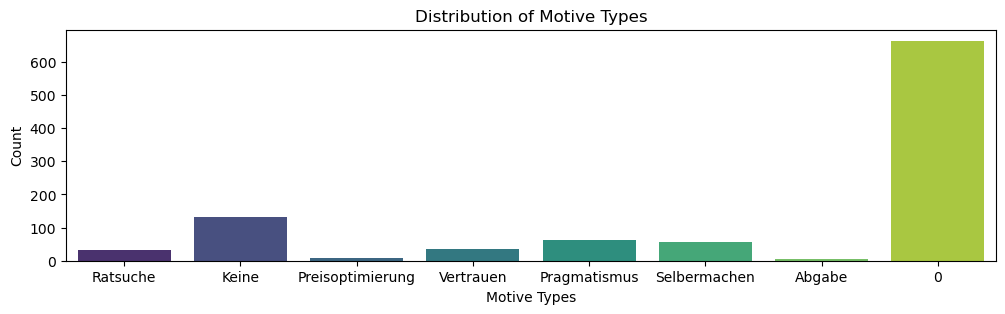

Counter({'0': 664,
         'Keine': 133,
         'Pragmatismus': 63,
         'Selbermachen': 58,
         'Vertrauen': 34,
         'Ratsuche': 33,
         'Preisoptimierung': 9,
         'Abgabe': 5})

In [7]:
plt.figure(figsize=(12, 3))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Motive Types')
plt.xlabel('Motive Types')
plt.ylabel('Count')
plt.show()
Counter(df.label)

In [8]:
# remove the Vermeidung / Abgabe/Preisoptimierung class, it was too less for training.
df = df[df['label'] != "Abgabe"]
df = df[df['label'] != "Preisoptimierung"]
df_l = df[df['label'] != "0"]
df_ul = df[df['label'] == "0"]
Counter(df_ul.label)

Counter({'0': 664})

#### Generate 2nd View

In [9]:
# #  Load a summarization model pipeline
# summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0 if torch.cuda.is_available() else -1)

# # Define a function to summarize a single document
# def summarize_text(text, max_length=150, min_length=30):
#     # Handle very short documents
#     if len(text.split()) < 50:
#         return "Text too short to summarize meaningfully."
#     try:
#         # Generate summary
#         summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
#         return summary[0]['summary_text']
#     except Exception as e:
#         return f"Error during summarization: {e}"

In [10]:
# # Summarize a few documents as examples
# example_summaries = [summarize_text(doc) for doc in df.text]

# # Print the original and summarized text
# for i, (original, summary) in enumerate(zip(df.text, example_summaries)):
#     print(f"Original Text {i+1}:\n{original[:500]}...\n")
#     print(f"Summary {i+1}:\n{summary}\n")
#     print("=" * 50)


# # # Print the original and summarized text
# # for i in range(5):
# #     print(f'original: {df.text[:5]}')
# #     print(f'summary: {example_summaries[i]}')
# #     print('XXXXXXX'*10)



In [11]:
# df['text_2'] = example_summaries

In [ ]:
# # Save the dataframe to a CSV file
# df.to_csv('tamedia_2view.csv', sep=',', index=False, encoding='utf-8')

In [12]:
# !pip install -U sentence-transformers 
# !pip install bert-extractive-summarizer

  Using cached sentence_transformers-3.3.1-py3-none-any.whl.metadata (10 kB)
Using cached sentence_transformers-3.3.1-py3-none-any.whl (268 kB)
  Using cached bert_extractive_summarizer-0.10.1-py3-none-any.whl.metadata (15 kB)
  Using cached spacy-3.8.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (27 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.11-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.0 kB)
  Using cached cymem-2.0.10-cp312-cp312-macosx_11_0_arm64.whl.metadata (8.4 kB)
  Using cached preshed-3.0.9-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.2 kB)
  Using cached thinc-8.3.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-

In [13]:
from summarizer.sbert import SBertSummarizer

# body = 'Text body that you want to summarize with BERT'
model = SBertSummarizer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
# summary = []
# for i,text in tqdm(enumerate(df.text)):
#   result = model(text, num_sentences=2)
#   summary.append(result)
#   if i == 10:
#     print(summary)
#     break

In [16]:
 
import re
 
repl = ['SPEAKER','SPEAKER_','SPEAKER_A','SPEAKER_B','Speaker', 'Sprecher_A','Sprecher_B','Sprecher_C','Sprecher_D','Sprecher_Unbekannt',
        'SPRECHER_A','SPRECHER_B','SPRECHER_C','SPRECHER_D','SPRECHER_UNBEKANNT']
 
def cleanTextDF(df, column):
    """Clean text in the specified column."""
    df['textClean'] = df[column].fillna('').astype(str)  # Ensure no NaN values and convert to string
    df['textClean'] = df['textClean'].str.replace(r'\d+', '', regex=True)  # Remove numbers
    # Remove anonymisation placeholders
    df['textClean'] = df['textClean'].str.replace(r'({Name}|{Nummer}|Strassenummer|{Stadt}|{Ort})', '', regex=True)
    # Remove punctuation except fullstop
    df['textClean'] = df['textClean'].str.replace(r'[,{}?!:;]', '', regex=True) 
    # Remove apostrophes
    df['textClean'] = df['textClean'].str.replace(r"[\"\',]", '', regex=True) 
    df['textClean'] = df['textClean'].apply(lambda x: ' '.join([word for word in x.split() if word not in repl]))
 
    return df['textClean']
 
df['textClean'] = cleanTextDF(df, 'text')
df.columns

Index(['label', 'text', 'textClean'], dtype='object')

In [17]:
summary = []
for i in tqdm(range(len(df['textClean']))):
  result = model(df.textClean.iloc[i], num_sentences=2)
  summary.append(result)
  # if i == 5:
  #   for text in summary:
  #     print(text)
  #   break


  0%|          | 0/985 [00:00<?, ?it/s]

In [18]:
df['textClean_2'] = summary
df.head()

,label,text,textClean,textClean_2
1,Ratsuche,"SPRECHER_A : Ich glaube , bei der Berner Zeitu...",Ich glaube bei der Berner Zeitung würde ich Ih...,Ich glaube bei der Berner Zeitung würde ich Ih...
2,Keine,"SPRECHER_B : Berner Zeitung , Aboservice , {Na...",Berner Zeitung Aboservice mein Name wie kann i...,Berner Zeitung Aboservice mein Name wie kann i...
4,Vertrauen,"SPRECHER_A : Schweizer Familie , Aboservice , ...",Schweizer Familie Aboservice mein Name wie kan...,Schweizer Familie Aboservice mein Name wie kan...
5,Vertrauen,"SPRECHER_A : Guten Tag , hier ist {Name} von d...",Guten Tag hier ist von der Passer-Zeitung . Ja...,Guten Tag hier ist von der Passer-Zeitung . We...
6,Pragmatismus,SPRECHER_A : Also sagen wir nochmals einen sch...,Also sagen wir nochmals einen schönen guten Ta...,Also sagen wir nochmals einen schönen guten Ta...


In [19]:
clean_df = df[['textClean_2','textClean','label']]
clean_df.to_csv('tamedia_2view_CLEAN.csv', sep=',', index=False, encoding='utf-8')
clean_df.head()


,textClean_2,textClean,label
1,Ich glaube bei der Berner Zeitung würde ich Ih...,Ich glaube bei der Berner Zeitung würde ich Ih...,Ratsuche
2,Berner Zeitung Aboservice mein Name wie kann i...,Berner Zeitung Aboservice mein Name wie kann i...,Keine
4,Schweizer Familie Aboservice mein Name wie kan...,Schweizer Familie Aboservice mein Name wie kan...,Vertrauen
5,Guten Tag hier ist von der Passer-Zeitung . We...,Guten Tag hier ist von der Passer-Zeitung . Ja...,Vertrauen
6,Also sagen wir nochmals einen schönen guten Ta...,Also sagen wir nochmals einen schönen guten Ta...,Pragmatismus


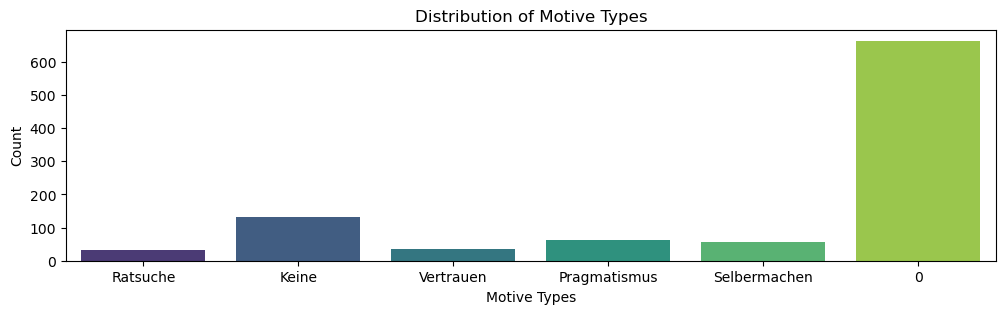

Counter({'0': 664,
         'Keine': 133,
         'Pragmatismus': 63,
         'Selbermachen': 58,
         'Vertrauen': 34,
         'Ratsuche': 33})

In [20]:
plt.figure(figsize=(12, 3))
sns.countplot(x='label', data=clean_df, palette='viridis')
plt.title('Distribution of Motive Types')
plt.xlabel('Motive Types')
plt.ylabel('Count')
plt.show()
Counter(clean_df.label)

In [21]:
df_l = clean_df[clean_df['label'] != "0"]
df_ul = clean_df[clean_df['label'] == "0"]
Counter(df_ul.label)

Counter({'0': 664})

In [22]:
Counter(df_l.label)

Counter({'Keine': 133,
         'Pragmatismus': 63,
         'Selbermachen': 58,
         'Vertrauen': 34,
         'Ratsuche': 33})

#### Vectorize - TFIDF


In [23]:
from sklearn.preprocessing import LabelEncoder
# label encoder
le = LabelEncoder()   ### ENCODE

y_encoded = le.fit_transform(df_l.label)

"""

# Decode labels back to original form if needed
y_resampled_decoded = le.inverse_transform(y_resampled)

"""


X_l_1 = df_l.textClean
X_l_2 = df_l.textClean_2

X_ul_1 = df_ul.textClean
X_ul_2 = df_ul.textClean_2

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words=None,
)
t0 = time()
X_l_1tfidf = vectorizer.fit_transform(X_l_1)
X_l_2tfidf = vectorizer.fit_transform(X_l_2)
X_ul_1tfidf = vectorizer.fit_transform(X_ul_1)
X_ul_2tfidf = vectorizer.fit_transform(X_ul_2)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_l_1tfidf.shape[0]}, n_features: {X_l_1tfidf.shape[1]}")

# feature reduction
lsa_1 = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
lsa_2 = make_pipeline(TruncatedSVD(n_components=20), Normalizer(copy=False))
t0 = time()


X_l_lsa_1 = lsa_1.fit_transform(X_l_1tfidf)
X_l_lsa_2 = lsa_2.fit_transform(X_l_2tfidf)
X_ul_lsa_1 = lsa_1.fit_transform(X_ul_1tfidf)
X_ul_lsa_2 = lsa_2.fit_transform(X_ul_2tfidf)

explained_variance = lsa_1[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")



vectorization done in 0.116 s
n_samples: 321, n_features: 838
LSA done in 0.110 s
Explained variance of the SVD step: 49.8%


#### SMOTE banlance data and splite the label data.

splite the labeld dataset to 50% train(reset) and test dataset.

In [24]:
# 
# Split data into train and test sets
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_l_lsa_1, y_encoded, test_size=0.5, random_state=42)
# Split data into train and test sets
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_l_lsa_2, y_encoded, test_size=0.5, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_1_resampled, y_1_resampled = smote.fit_resample(X_1_train, y_1_train)
X_2_resampled, y_2_resampled = smote.fit_resample(X_2_train, y_2_train)

# Check distribution
print("Before SMOTE:", Counter(y_1_train))
print("After SMOTE:", Counter(y_1_resampled))
print("Before SMOTE:", X_1_train.shape)
print("After SMOTE  x:", X_1_resampled.shape)
print("After SMOTE  y:", y_1_resampled.shape)
print("X_1_test:", X_1_test.shape)
print("X_1_ul:", X_ul_lsa_1.shape)


# Check distribution
print("Before SMOTE:", Counter(y_2_train))
print("After SMOTE:", Counter(y_2_resampled))
print("Before SMOTE:", X_2_train.shape)
print("After SMOTE:", X_2_resampled.shape)
print("X_2_test:", X_2_test.shape)
print("X_2_ul:", X_ul_lsa_2.shape)



Before SMOTE: Counter({0: 64, 1: 34, 3: 28, 4: 17, 2: 17})
After SMOTE: Counter({4: 64, 3: 64, 0: 64, 1: 64, 2: 64})
Before SMOTE: (160, 100)
After SMOTE  x: (320, 100)
After SMOTE  y: (320,)
X_1_test: (161, 100)
X_1_ul: (664, 100)
Before SMOTE: Counter({0: 64, 1: 34, 3: 28, 4: 17, 2: 17})
After SMOTE: Counter({4: 64, 3: 64, 0: 64, 1: 64, 2: 64})
Before SMOTE: (160, 20)
After SMOTE: (320, 20)
X_2_test: (161, 20)
X_2_ul: (664, 20)


## Define CoRL environment   /CLFS / ENVS / RLm-Actor created networks

In [25]:

# Initialize classifiers (KNN and SVM)

svm_1 = SVC(kernel='rbf', probability=True, tol=1e-4, max_iter=10000, C=1.0)
svm_2 = SVC(kernel='rbf', probability=True, tol=1e-4, max_iter=10000, C=1.0)
classifiers = [svm_1, svm_2]

In [26]:
# define ENV

# for clustering the unlabeld data

class Env():
    def __init__(self, classifiers, input_ul_data_1, input_ul_data_2, k, X_test_1, y_test_1, X_reset_1, y_reset_1, X_test_2, y_test_2, X_reset_2, y_reset_2):
        # super().__init__
        self.models = classifiers
    
        # UN LABEL DATA
        self.X_ul_1 = input_ul_data_1
        self.X_ul_2 = input_ul_data_2
        # define the evaluate data, later use for the reward
        self.X_eval_1 = X_test_1
        self.y_eval_1 = y_test_1
        self.X_reset_1 = X_reset_1
        self.y_reset_1 = y_reset_1
        self.X_eval_2 = X_test_2
        self.y_eval_2 = y_test_2
        self.X_reset_2 = X_reset_2
        self.y_reset_2 = y_reset_2

        # cluster the data
        self.action_size = k
        self.kmeans_1 = KMeans(n_clusters=k,  n_init=10)
        self.kmeans_2 = KMeans(n_clusters=k,  n_init=10)
        self.cluster_label_1 = self.kmeans_1.fit_predict(self.X_ul_1)
        self.cluster_label_2 = self.kmeans_2.fit_predict(self.X_ul_2)
        # self.u_cluster_label_1 = np.unique(self.cluster_label_1)
        # self.u_cluster_label_2 = np.unique(self.cluster_label_2)
        self.centroids_1 = self.kmeans_1.cluster_centers_
        self.centroids_2 = self.kmeans_2.cluster_centers_
        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0

    # update 2 clf
    def train_2_clf(self, X_1, y_1, X_2, y_2):
        # print("Shapes X_1:", X_1.shape, "y_1:", y_1.shape)
        # print("Shapes X_2:", X_2.shape, "y_2:", y_2.shape)
        self.models[0].fit(X_1, y_1)
        self.models[1].fit(X_2, y_2)

    def get_state(self, reset=False):
        """
        Generate a state representation by predicting probabilities on centroids using stored models.
        Optionally resets and retrains models using X_reset and y_reset.

        :param reset: Boolean flag to reset and retrain models before prediction.
        :return: Torch tensor of concatenated probabilities reshaped as (1, -1).
        """
        if reset:
            if self.X_reset_1 is not None and self.y_reset_1 is not None:
                self.train_2_clf(X_1=self.X_reset_1, y_1=self.y_reset_1, X_2=self.X_reset_2, y_2=self.y_reset_2)
            else:
                raise ValueError("Reset datasets X_reset or y_reset are not provided.")
        
        if not hasattr(self, 'models') or len(self.models) < 2:
            raise ValueError("Model list is incomplete or not set.")

        try:
            out_1 = self.models[0].predict_proba(self.centroids_1)
            out_2 = self.models[1].predict_proba(self.centroids_2)
        except Exception as e:
            raise RuntimeError("Model prediction failed: " + str(e))
        
        state_proba = np.concatenate((out_1, out_2), axis=1)
        return torch.from_numpy(state_proba).to(torch.float32).reshape(1, -1)


    def get_f1(self):

        classifier_weights = [self.models[0].score(self.X_eval_1, self.y_eval_1), self.models[1].score(self.X_eval_2, self.y_eval_2)]  # Weights based on validation accuracy
        combined_probabilities = np.average(
            [self.models[0].predict_proba(self.X_eval_1), self.models[1].predict_proba(self.X_eval_2)],
            axis=0,
            weights=classifier_weights
        )

        # Get final predictions from combined probabilities
        combined_predictions = np.argmax(combined_probabilities, axis=1)

        # Calculate F1 scores per class (harmonic means)
        f1_macro = f1_score(self.y_eval_1, combined_predictions, average='macro')
        f1_micro = f1_score(self.y_eval_1, combined_predictions, average='micro')

        return f1_macro, f1_micro

    ######
    ######
    def get_subset(self, action):
        # choose subset
        subset_1 = self.X_ul_1[self.cluster_label_1 == action]
        subset_2 = self.X_ul_2[self.cluster_label_1 == action]
        return subset_1, subset_2

    def co_training(self, subset_1, subset_2):

        # Average class probabilities across classifiers

        avg_probabilities_1 = self.models[0].predict_proba(subset_1)
        avg_probabilities_2 = self.models[1].predict_proba(subset_2)

        # Assign the label with the highest average probability

        y_ul_action_1 = np.argmax(avg_probabilities_1, axis=1)
        y_ul_action_2 = np.argmax(avg_probabilities_2, axis=1)
        # print(y_ul_action)

        ########### update the label_set for traning
        X_updated_1 = np.concatenate((self.X_reset_1, subset_1), axis=0)
        y_updated_1 = np.concatenate((self.y_reset_1, y_ul_action_2), axis=0)

        X_updated_2 = np.concatenate((self.X_reset_2, subset_2), axis=0)
        y_updated_2 = np.concatenate((self.y_reset_2, y_ul_action_1), axis=0)

        ############# use the updated labeld dateset retrain those 2 classifier
        self.train_2_clf(X_1=X_updated_1, y_1=y_updated_1, X_2=X_updated_2, y_2=y_updated_2)

       
        return self.get_f1()

    def step(self, action):
        # GET THE bigining state accuracy, later use to calculate the reward
        macrof1, microf1 = self.get_f1()

        # choose subset
        choosen_subset_1, choosen_subset_2 =  self.get_subset(action)


        # cotraining the 2 classifier
        new_marco_f1, new_micro_f1 = self.co_training(choosen_subset_1, choosen_subset_2)

        # get the next state_
        n_state = self.get_state()

        ##############
        # calculate the reward
        ##############
        if new_marco_f1 > macrof1:
            reward_0 = new_marco_f1 - macrof1
        else:
            reward_0 = 0

        return n_state, reward_0, new_marco_f1, new_micro_f1


In [27]:
k = 400
env = Env(classifiers=classifiers, 
        input_ul_data_1=X_ul_lsa_1,
        input_ul_data_2=X_ul_lsa_2, 
        k=k, 
        X_test_1=X_1_test, 
        X_test_2=X_2_test,
        y_test_1=y_1_test, 
        y_test_2=y_2_test, 
        X_reset_1=X_1_resampled,
        X_reset_2=X_2_resampled, 
        y_reset_1=y_1_resampled, 
        y_reset_2=y_2_resampled
        )



In [28]:
# env.get_state(reset=True)
# # svm_1.fit(X_1_train,y_1_train)
# # svm_2.fit(X_2_test,y_2_test)
# s1, s2 = env.get_subset(4)
# s2.shape
# s1.shape

# env.get_f1()



In [29]:
# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        # Shared layers
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Actor: outputs action probabilities (softmax)
        self.actor = nn.Linear(128, action_size)


        # Critic: outputs state value (for advantage calculation)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Policy (actor): softmax over actions
        action_probs = torch.softmax(self.actor(x), dim=-1)

        # Value (critic): state value estimation
        state_value = self.critic(x)

        return action_probs, state_value

In [30]:


actor_critic = ActorCritic(state_size=env.observation_size, action_size=env.action_size)
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)
# Training parameters
num_episodes = 200
gamma = 0.99
results = []

In [31]:

episode_rewards = []
episode_f1s = []
macro_f1_scores = []
micro_f1_scores = []

# Main training loop


for episode in tqdm(range(num_episodes)):
    state = env.get_state(reset=True)
    # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    episode_reward = 0
    episode_loss = 0.00

    for t in range(1, 400):  # Limit the number of time steps
        # No need to use GradientTape; PyTorch handles gradients automatically
        # Choose an action using the actor
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()


        # Take the chosen action and observe the next state and reward
        next_state, reward, macro_f1, micro_f1 = env.step(action.item())
        # next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # print(f" t: {t}  next_state.shape {next_state.shape} ")

        # Compute the advantage
        # _, state_value = actor_critic(state)
        _, next_state_value = actor_critic(next_state)
        advantage = reward + gamma * next_state_value - state_value

        # Compute actor and critic losses
        actor_loss = -dist.log_prob(action) * advantage.detach()
        critic_loss = advantage.pow(2)

        # Combine losses for joint update
        total_loss = actor_loss + critic_loss

        # Update actor and critic
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        state = next_state
        episode_reward += reward
        episode_loss += total_loss
        episode_f1s.append(macro_f1)
        if episode == num_episodes - 1:
            macro_f1_scores.append(macro_f1)
            micro_f1_scores.append(micro_f1)

    episode_rewards.append(episode_reward)

    if episode % 10 == 0:
        print(f" Episode {episode}, Reward: {episode_reward}  AC losses:{episode_loss}")
results.append([episode_rewards, episode_f1s, macro_f1_scores, micro_f1_scores])

  0%|          | 0/200 [00:00<?, ?it/s]

 Episode 0, Reward: 3.149483886064088  AC losses:tensor([[0.3995]], grad_fn=<AddBackward0>)
 Episode 10, Reward: 2.8397611256865045  AC losses:tensor([[0.0428]], grad_fn=<AddBackward0>)
 Episode 20, Reward: 2.8788104976304303  AC losses:tensor([[0.0330]], grad_fn=<AddBackward0>)
 Episode 30, Reward: 2.7933155795899514  AC losses:tensor([[0.0319]], grad_fn=<AddBackward0>)
 Episode 40, Reward: 2.683995209477667  AC losses:tensor([[0.0364]], grad_fn=<AddBackward0>)
 Episode 50, Reward: 2.6854430802495983  AC losses:tensor([[-0.0458]], grad_fn=<AddBackward0>)
 Episode 60, Reward: 2.6532962288210555  AC losses:tensor([[0.0307]], grad_fn=<AddBackward0>)
 Episode 70, Reward: 2.643063083413928  AC losses:tensor([[0.0317]], grad_fn=<AddBackward0>)
 Episode 80, Reward: 3.2066693214722424  AC losses:tensor([[0.7020]], grad_fn=<AddBackward0>)
 Episode 90, Reward: 3.2597763093207615  AC losses:tensor([[0.0668]], grad_fn=<AddBackward0>)
 Episode 100, Reward: 3.315755193058757  AC losses:tensor([[-0.

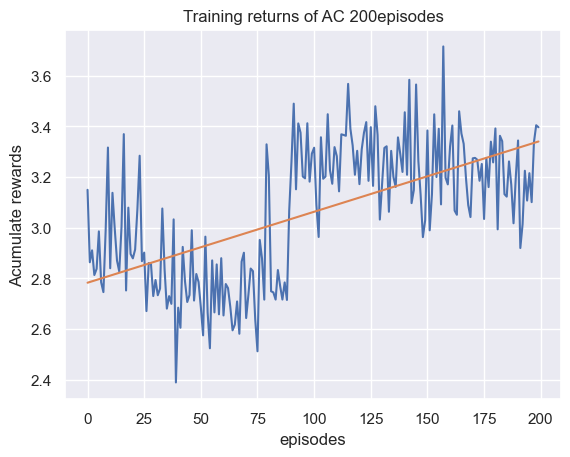

In [32]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(episode_rewards)
plt.ylabel('Acumulate rewards')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(episode_rewards)).reshape(-1, 1), np.array(episode_rewards).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(episode_rewards)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

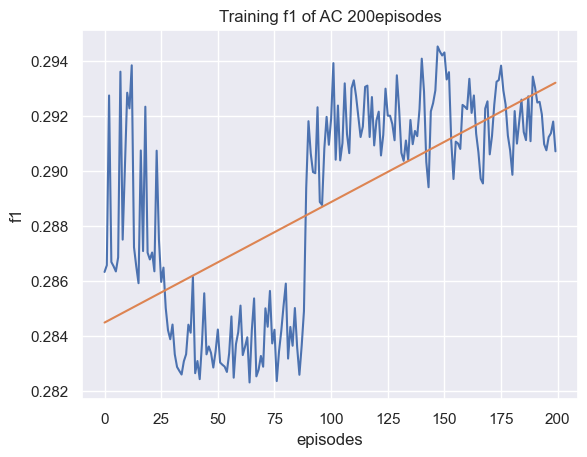

In [33]:


def calculate_averages(numbers):
  """Calculates the average of every 10 consecutive numbers in a list.

  Args:
    numbers: A list of numbers.

  Returns:
    A list of averages, each representing the average of 10 consecutive numbers.
  """

  averages = []
  for i in range(0, len(numbers), 400):
    chunk = numbers[i:i+400]
    average = sum(chunk) / len(chunk)
    averages.append(average)
  return averages

# # Example usage:
# my_list = [1, 2, 3, ..., 200]  # Replace with your actual list of 200 numbers
result = calculate_averages(episode_f1s)
# print(result)

sns.set()

plt.plot(result)
plt.ylabel('f1')
plt.xlabel('episodes')
plt.title(f'Training f1 of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(result)).reshape(-1, 1), np.array(result).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(result)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [34]:
env.get_f1()

(0.2869007263922517, 0.484472049689441)

### DNN classifier


In [ ]:
# batch_size = 32
# # ############

# # Convert numpy arrays to PyTorch tensors

# X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32,requires_grad=True)
# y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)  # Use long for classification tasks

# X_test_tensor = torch.tensor(X_test, dtype=torch.float32,requires_grad=True)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # Use long for classification tasks

# # Define a custom Dataset class
# class BuildDataset():
#     def __init__(self, features, labels):
#         self.features = features
#         self.labels = labels

#     def __len__(self):
#         return len(self.features)

#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]

# # Create Dataset object
# train_dataset = BuildDataset(X_train_tensor, y_train_tensor)
# test_dataset = BuildDataset(X_test_tensor, y_test_tensor)

# # ###########
# trainloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
#                                           shuffle=True)

# testloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
#                                          shuffle=False)

# # define 2 NN classifiers
# class NeuralNet(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(NeuralNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # print(f"Input requires_grad: {x.requires_grad}")  
#         x = F.relu(self.fc1(x))
#         # print(f"After layer1 requires_grad: {x.requires_grad}") 
#         proba = F.softmax(self.fc2(x), dim=1)
#         # print(f"After proba requires_grad: {proba.requires_grad}")
#         label = self.fc2(x)
#         # print(f"After label requires_grad: {label.requires_grad}")
#         return proba, label
    
#     def score(self, X, y):
#         _, out = self.forward(X)
#         out = out.detach().numpy()
#         score_1 = accuracy_score(y_pred=out, y_true=y)
#         return score_1


# model1 = NeuralNet(input_size=100, hidden_size=128, output_size=20)
# optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
# loss1 = nn.CrossEntropyLoss()




In [ ]:
# for epoch in range(200):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         optimizer1.zero_grad()


#         # forward + backward + optimize
#         probas, outputs = model1(inputs)
#         loss = loss1(outputs, labels)
#         loss.backward()
#         optimizer1.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 200 == 1:    # print every 2000 mini-batches
#             print(f'[EPOCH {epoch + 1}, {i + 1:5d}] loss: {running_loss / 4:.3f}')

# print('Finished Training')

[EPOCH 1,     2] loss: 1.500
[EPOCH 2,     2] loss: 1.446
[EPOCH 3,     2] loss: 1.393
[EPOCH 4,     2] loss: 1.313
[EPOCH 5,     2] loss: 1.228
[EPOCH 6,     2] loss: 1.098
[EPOCH 7,     2] loss: 0.986
[EPOCH 8,     2] loss: 0.892
[EPOCH 9,     2] loss: 0.800
[EPOCH 10,     2] loss: 0.752
[EPOCH 11,     2] loss: 0.693
[EPOCH 12,     2] loss: 0.665
[EPOCH 13,     2] loss: 0.632
[EPOCH 14,     2] loss: 0.585
[EPOCH 15,     2] loss: 0.530
[EPOCH 16,     2] loss: 0.487
[EPOCH 17,     2] loss: 0.422
[EPOCH 18,     2] loss: 0.429
[EPOCH 19,     2] loss: 0.369
[EPOCH 20,     2] loss: 0.349
[EPOCH 21,     2] loss: 0.343
[EPOCH 22,     2] loss: 0.268
[EPOCH 23,     2] loss: 0.298
[EPOCH 24,     2] loss: 0.214
[EPOCH 25,     2] loss: 0.227
[EPOCH 26,     2] loss: 0.287
[EPOCH 27,     2] loss: 0.233
[EPOCH 28,     2] loss: 0.187
[EPOCH 29,     2] loss: 0.209
[EPOCH 30,     2] loss: 0.189
[EPOCH 31,     2] loss: 0.233
[EPOCH 32,     2] loss: 0.191
[EPOCH 33,     2] loss: 0.190
[EPOCH 34,     2] l

In [ ]:
# # GET f1 score of the NN classifiers.
# _, out_result = model1(X_test_tensor)

# NN_f1_marco = f1_score(y_pred=torch.argmax(out_result, axis=1).detach().numpy(),y_true=y_test, average='macro')
# NN_f1_mirco = f1_score(y_pred=torch.argmax(out_result, axis=1).detach().numpy(),y_true=y_test, average='micro')

# print(f'nn classifier F1 Macro: {NN_f1_marco} \nnn classifier F1 Micro: {NN_f1_mirco}')

nn classifier F1 Macro: 0.33059516054327026 
nn classifier F1 Micro: 0.4409937888198758


### SVM classifiers

In [ ]:
# # Initialize the SVM classifier with One-vs-All strategy

# # knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
# # svm = SVC(kernel='rbf', probability=True, tol=1e-4, max_iter=10000, C=1.0)


# svm_ova = SVC(decision_function_shape='ovr')
# svm_ova.fit(X=X_resampled, y=y_resampled)

# # Predict and evaluate the One-vs-All model
# y_pred_ova = svm_ova.predict(X_test)
# print("One-vs-All F1 Macro:", f1_score(y_true=y_test, y_pred=y_pred_ova, average='macro'))
# print("One-vs-All F1 Micro:", f1_score(y_true=y_test, y_pred=y_pred_ova, average='micro'))


One-vs-All F1 Macro: 0.2973160173160173
One-vs-All F1 Micro: 0.484472049689441


### KNN classifiers

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_resampled)
# X_test_scaled = scaler.transform(X_test)

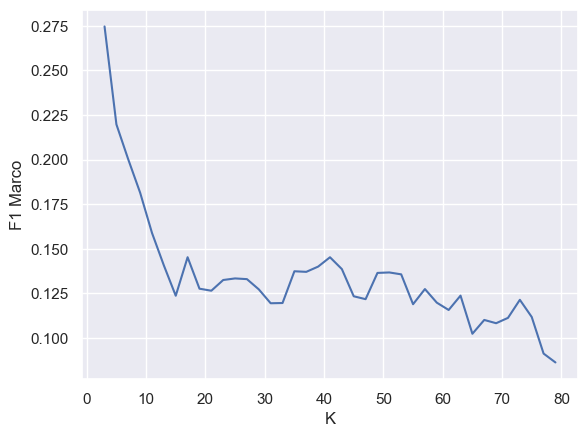

'\nk = 3 have the higest f1 score\n\n'

In [ ]:
# F1 = {}
# for k in range(3, 80, 2):
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train_scaled, y_resampled)
#     y_pred = knn.predict(X_test_scaled)
#     F1[k] = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    
# # PLotting K v/s accuracy graph
# plt.plot(range(3,80,2), F1.values())
# plt.xlabel('K')
# plt.ylabel('F1 Marco')
# plt.show()


# '''
# k = 3 have the higest f1 score

# '''

In [ ]:
# from sklearn.metrics import accuracy_score, classification_report
# knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(X_train_scaled, y_resampled)
# y_pred = knn.predict(X_test_scaled)
# print(accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# print("KNN F1 Macro:", f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
# print("KNN F1 Micro:", f1_score(y_true=y_test, y_pred=y_pred, average='micro'))

0.2919254658385093
              precision    recall  f1-score   support

           0       0.73      0.28      0.40        69
           1       0.27      0.31      0.29        29
           2       0.10      0.25      0.14        16
           3       0.29      0.33      0.31        30
           4       0.19      0.29      0.23        17

    accuracy                           0.29       161
   macro avg       0.32      0.29      0.27       161
weighted avg       0.45      0.29      0.32       161

KNN F1 Macro: 0.27466235093256075
KNN F1 Micro: 0.2919254658385093
